<a href="https://colab.research.google.com/github/AdityaPatil-R/AICHL/blob/main/AICHL_Disambiguation_Visualizations_Aditya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
#@title Installations

!pip install --upgrade openai
!pip install --upgrade pyclustering
!pip install -U transformers
!pip install hdbscan
!pip install kmedoids
!pip install scikit-learn-extra
!pip install mplcursors
!pip install spacy
!pip install gspread
!pip install seaborn
!pip install plotly


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new rel

In [ ]:
#@title Imports

# Imports
import os
import re
import json
import math
import nltk
import glob
import torch
import spacy
import gspread
import hdbscan
import warnings
import kmedoids
import mplcursors
import transformers

# Imports as
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# pyclustering
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# scipy
from scipy.sparse import csgraph
from scipy.linalg import eigvals
from scipy.sparse.linalg import eigs
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform

# sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score, calinski_harabasz_score, confusion_matrix

# Miscellaneous
from openai import OpenAI
from textwrap import dedent
from typing import List, Type
from google.auth import default
from nltk.corpus import wordnet as wn
from IPython.display import HTML, display
from collections import defaultdict, Counter
from pydantic import BaseModel, Field, TypeAdapter
from google.colab import userdata, drive, files, auth
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#@title Clean output

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
#@title Mount Google Drive

drive.mount('/content/drive')

# Create new dataframe

In [ ]:
#@title Create data frame

path = '/content/drive/MyDrive/Files1-10.xlsx' # use your path

fortunoff_df = pd.read_excel(path)

# Create an index column as reference (Used later for answer extraction)
fortunoff_df['manual_index'] = list(range(1, len(fortunoff_df) + 1))
fortunoff_df = fortunoff_df.reset_index(drop = True)

fortunoff_df

,file_num,file_part,time,speaker,text,is_interviewee,chain_of_thought,is_question,contains_unresolved_pronoun,enough_context_provided,disambiguated_text,chain_of_thoughts,is_follow_up_question,is_complete_sentence,sufficient_context_provided,question_with_additional_context,needs_context_rewriting,needs_pronoun_disambiguation,final_text,manual_index
0,1,1,00:00:03.300000,INTERVIEWER 1,We're going to go back into the past. Where ar...,0,"In the Current Text, the phrase ""Where are you...",True,False,True,NaN,The Current Text is a direct quotation of what...,False,True,False,NaN,False,False,We're going to go back into the past. Where ar...,1
1,1,1,00:00:17.880000,INTERVIEWER 1,Where?,0,"In the Previous Context, the interviewee menti...",True,False,True,NaN,The Current Text 'Where?' is a follow-up quest...,True,False,True,Where in Czechoslovakia did you grow up?,True,False,Where in Czechoslovakia did you grow up?,2
2,1,1,00:00:23.530000,INTERVIEWER 1,Do you remember the old city?,0,The Current Text is a question directed at the...,True,False,True,NaN,The Current Text is a follow-up question to th...,True,True,True,"Do you remember the old city, where you spent ...",False,False,Do you remember the old city?,3
3,1,1,00:00:42.400000,INTERVIEWER 2,"As a Jewish person, did you feel any differenc...",0,"The Current Text contains the pronouns ""you"" a...",True,False,True,NaN,The Current Text is a follow-up question regar...,True,False,True,"As a Jewish person growing up in Prague, did y...",True,False,"As a Jewish person growing up in Prague, did y...",4
4,1,1,00:00:53.120000,INTERVIEWER 2,Would you mind repeating my question so that i...,0,The Current Text is a question directed toward...,True,False,True,NaN,The Current Text is indeed a follow-up questio...,True,False,True,Would you mind repeating my question about dis...,True,False,Would you mind repeating my question about dis...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,10,2,01:00:18.720000,INTERVIEWER 2,Do you think about it when you don't expect to...,0,The Current Text is a question directed toward...,True,False,True,NaN,The Current Text is indeed a follow-up questio...,True,False,True,Do you think about your experiences during the...,True,False,Do you think about your experiences during the...,687
687,10,2,01:01:24.490000,INTERVIEWER 1,Do you feel--,0,The current text is a question posed by the in...,True,False,True,NaN,"The Current Text ""Do you feel--"" is an incompl...",True,False,True,Do you feel that these memories and emotions e...,True,False,Do you feel that these memories and emotions e...,688
688,10,2,01:01:26.100000,INTERVIEWER 1,--different from the others?,0,"In the Current Text, the interviewer is asking...",True,False,True,NaN,The Current Text is a follow-up question to th...,True,False,True,Do you feel that your experiences have made yo...,True,False,Do you feel that your experiences have made yo...,689
689,10,2,01:01:27.800000,INTERVIEWER 1,Do you feel different? From--,0,"In the Current Text, the interviewer is asking...",True,False,True,Do you feel different from others?,The Current Text is a follow-up question relat...,True,False,True,"Do you feel different from others, especially ...",True,False,"Do you feel different from others, especially ...",690


In [ ]:
#@title Add embeddings (~7 min)

# Set the environment variable to the access token
os.environ["OPEN_AI_KEY"] = userdata.get('OPEN_AI_PROJECT_KEY')

# Pass the API key to Open AI
client = OpenAI(api_key = os.environ.get("OPEN_AI_KEY"))

# Define the model
MODEL = "gpt-4o-mini"

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = text, model=model).data[0].embedding

text_embeddings = []
final_text_embeddings = []

for i in range(len(fortunoff_df)):
    text_embeddings.append(get_embedding(fortunoff_df.text.iloc[i]))
    final_text_embeddings.append(get_embedding(fortunoff_df.final_text.iloc[i]))

fortunoff_df['text_embeddings'] = text_embeddings
fortunoff_df['final_text_embeddings'] = final_text_embeddings

fortunoff_df

,file_num,file_part,time,speaker,text,is_interviewee,chain_of_thought,is_question,contains_unresolved_pronoun,enough_context_provided,...,is_follow_up_question,is_complete_sentence,sufficient_context_provided,question_with_additional_context,needs_context_rewriting,needs_pronoun_disambiguation,final_text,manual_index,text_embeddings,final_text_embeddings
0,1,1,00:00:03.300000,INTERVIEWER 1,We're going to go back into the past. Where ar...,0,"In the Current Text, the phrase ""Where are you...",True,False,True,...,False,True,False,NaN,False,False,We're going to go back into the past. Where ar...,1,"[0.007100808899849653, 0.000985543243587017, 0...","[0.007100808899849653, 0.000985543243587017, 0..."
1,1,1,00:00:17.880000,INTERVIEWER 1,Where?,0,"In the Previous Context, the interviewee menti...",True,False,True,...,True,False,True,Where in Czechoslovakia did you grow up?,True,False,Where in Czechoslovakia did you grow up?,2,"[-0.007700302172452211, 0.01364236231893301, 0...","[-0.027627483010292053, -0.0010306346230208874..."
2,1,1,00:00:23.530000,INTERVIEWER 1,Do you remember the old city?,0,The Current Text is a question directed at the...,True,False,True,...,True,True,True,"Do you remember the old city, where you spent ...",False,False,Do you remember the old city?,3,"[-0.014205072075128555, -0.061346739530563354,...","[-0.014151963405311108, -0.06129411235451698, ..."
3,1,1,00:00:42.400000,INTERVIEWER 2,"As a Jewish person, did you feel any differenc...",0,"The Current Text contains the pronouns ""you"" a...",True,False,True,...,True,False,True,"As a Jewish person growing up in Prague, did y...",True,False,"As a Jewish person growing up in Prague, did y...",4,"[0.005144532769918442, -0.006464041769504547, ...","[-0.013541433028876781, 0.009313649497926235, ..."
4,1,1,00:00:53.120000,INTERVIEWER 2,Would you mind repeating my question so that i...,0,The Current Text is a question directed toward...,True,False,True,...,True,False,True,Would you mind repeating my question about dis...,True,False,Would you mind repeating my question about dis...,5,"[0.036914173513650894, -0.029073335230350494, ...","[0.07409097999334335, -0.01303546130657196, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,10,2,01:00:18.720000,INTERVIEWER 2,Do you think about it when you don't expect to...,0,The Current Text is a question directed toward...,True,False,True,...,True,False,True,Do you think about your experiences during the...,True,False,Do you think about your experiences during the...,687,"[0.028348270803689957, -0.01200272236019373, 0...","[0.005724273156374693, -0.002997001865878701, ..."
687,10,2,01:01:24.490000,INTERVIEWER 1,Do you feel--,0,The current text is a question posed by the in...,True,False,True,...,True,False,True,Do you feel that these memories and emotions e...,True,False,Do you feel that these memories and emotions e...,688,"[0.06545407325029373, -0.033535879105329514, -...","[0.020477114245295525, -0.0336734764277935, -0..."
688,10,2,01:01:26.100000,INTERVIEWER 1,--different from the others?,0,"In the Current Text, the interviewer is asking...",True,False,True,...,True,False,True,Do you feel that your experiences have made yo...,True,False,Do you feel that your experiences have made yo...,689,"[-0.007022941019386053, -0.015285912901163101,...","[0.01704610511660576, -0.0677480399608612, -0...."
689,10,2,01:01:27.800000,INTERVIEWER 1,Do you feel different? From--,0,"In the Current Text, the interviewer is asking...",True,False,True,...,True,False,True,"Do you feel different from others, especially ...",True,False,"Do you feel different from others, especially ...",690,"[0.03737577050924301, -0.031203364953398705, -...","[0.010409644804894924, -0.04062793403863907, -..."


In [ ]:
#@title Save embeddings

output_file_name = 'Fortunoff_Holocaust_Testimonies_2020_Files_1-10_Embeddings'
fortunoff_df.to_csv(f'{output_file_name}.csv', index=False)

files.download(f'{output_file_name}.csv')

auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

# Create a new spreadsheet
spreadsheet = gc.create(output_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Use Saved Dataframe

In [ ]:
#@title Read in old dataframe

fortunoff_df = pd.read_excel('/content/drive/MyDrive/Fortunoff_Holocaust_Testimonies_2020_Files_1-10_Embeddings.xlsx')

fortunoff_df

,file_num,file_part,time,speaker,text,is_interviewee,chain_of_thought,is_question,contains_unresolved_pronoun,enough_context_provided,...,is_follow_up_question,is_complete_sentence,sufficient_context_provided,question_with_additional_context,needs_context_rewriting,needs_pronoun_disambiguation,final_text,manual_index,text_embeddings,final_text_embeddings
0,1,1,00:00:03.300000,INTERVIEWER 1,We're going to go back into the past. Where ar...,0,"In the Current Text, the phrase ""Where are you...",True,False,True,...,False,True,False,NaN,False,False,We're going to go back into the past. Where ar...,1,"[0.007100808899849653, 0.000985543243587017, 0...","[0.007100808899849653, 0.000985543243587017, 0..."
1,1,1,00:00:17.880000,INTERVIEWER 1,Where?,0,"In the Previous Context, the interviewee menti...",True,False,True,...,True,False,True,Where in Czechoslovakia did you grow up?,True,False,Where in Czechoslovakia did you grow up?,2,"[-0.007700302172452211, 0.01364236231893301, 0...","[-0.027627483010292053, -0.0010306346230208874..."
2,1,1,00:00:23.530000,INTERVIEWER 1,Do you remember the old city?,0,The Current Text is a question directed at the...,True,False,True,...,True,True,True,"Do you remember the old city, where you spent ...",False,False,Do you remember the old city?,3,"[-0.014205072075128555, -0.061346739530563354,...","[-0.014151963405311108, -0.06129411235451698, ..."
3,1,1,00:00:42.400000,INTERVIEWER 2,"As a Jewish person, did you feel any differenc...",0,"The Current Text contains the pronouns ""you"" a...",True,False,True,...,True,False,True,"As a Jewish person growing up in Prague, did y...",True,False,"As a Jewish person growing up in Prague, did y...",4,"[0.005144532769918442, -0.006464041769504547, ...","[-0.013541433028876781, 0.009313649497926235, ..."
4,1,1,00:00:53.120000,INTERVIEWER 2,Would you mind repeating my question so that i...,0,The Current Text is a question directed toward...,True,False,True,...,True,False,True,Would you mind repeating my question about dis...,True,False,Would you mind repeating my question about dis...,5,"[0.036914173513650894, -0.029073335230350494, ...","[0.07409097999334335, -0.01303546130657196, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,10,2,01:00:18.720000,INTERVIEWER 2,Do you think about it when you don't expect to...,0,The Current Text is a question directed toward...,True,False,True,...,True,False,True,Do you think about your experiences during the...,True,False,Do you think about your experiences during the...,687,"[0.028348270803689957, -0.01200272236019373, 0...","[0.005724273156374693, -0.002997001865878701, ..."
687,10,2,01:01:24.490000,INTERVIEWER 1,Do you feel--,0,The current text is a question posed by the in...,True,False,True,...,True,False,True,Do you feel that these memories and emotions e...,True,False,Do you feel that these memories and emotions e...,688,"[0.06545407325029373, -0.033535879105329514, -...","[0.020477114245295525, -0.0336734764277935, -0..."
688,10,2,01:01:26.100000,INTERVIEWER 1,--different from the others?,0,"In the Current Text, the interviewer is asking...",True,False,True,...,True,False,True,Do you feel that your experiences have made yo...,True,False,Do you feel that your experiences have made yo...,689,"[-0.007022941019386053, -0.015285912901163101,...","[0.01704610511660576, -0.0677480399608612, -0...."
689,10,2,01:01:27.800000,INTERVIEWER 1,Do you feel different? From--,0,"In the Current Text, the interviewer is asking...",True,False,True,...,True,False,True,"Do you feel different from others, especially ...",True,False,"Do you feel different from others, especially ...",690,"[0.03737577050924301, -0.031203364953398705, -...","[0.010409644804894924, -0.04062793403863907, -..."


# Visualizations

In [ ]:
#@title Prepare

# Assuming comparison_df is already loaded
df = fortunoff_df

# Convert the embeddings back to an np array
df['text_embeddings'] = df['text_embeddings'].apply(lambda x: eval(str(x)))
embeddings = np.stack(df['text_embeddings'].values)

df['final_text_embeddings'] = df['final_text_embeddings'].apply(lambda x: eval(str(x)))
context_embeddings = np.stack(df['final_text_embeddings'].values)

# Normalize the embeddings to unit length (for cosine similarity)
embeddings = normalize(embeddings, norm='l2')
context_embeddings = normalize(context_embeddings, norm='l2')

# Guess what the max k should be
max_k_guess = len(df)

## K-Means

### Finding Optimal K

#### Silhouette Analyses / Elbow Method

Before


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (677) found smaller than n_clusters (678). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (677) found smaller than n_clusters (679). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (677) found smaller than n_clusters (680). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (677) found smaller than n_clusters (681). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/

Optimal K - 418


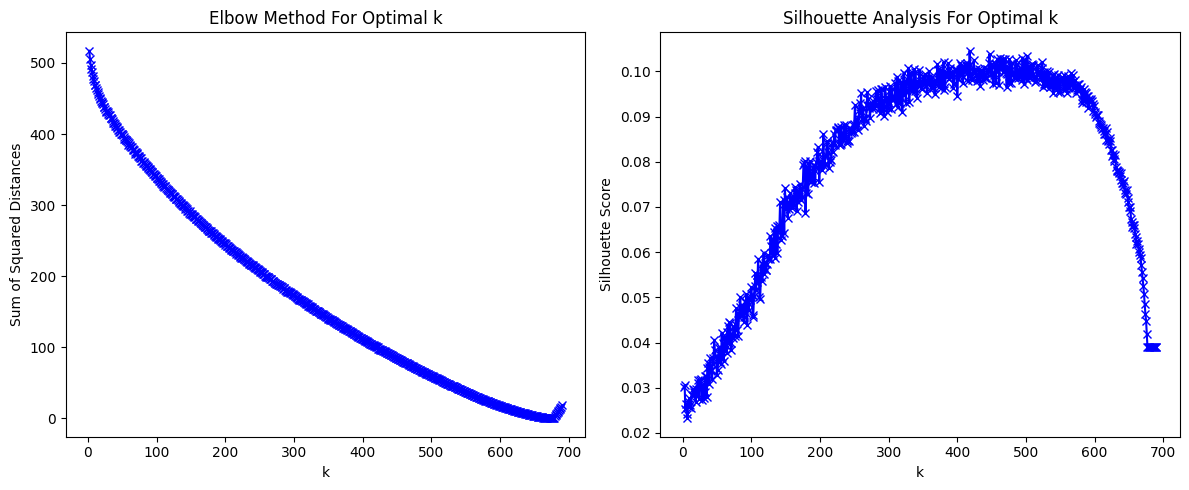

After


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (689) found smaller than n_clusters (690). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Optimal K - 382


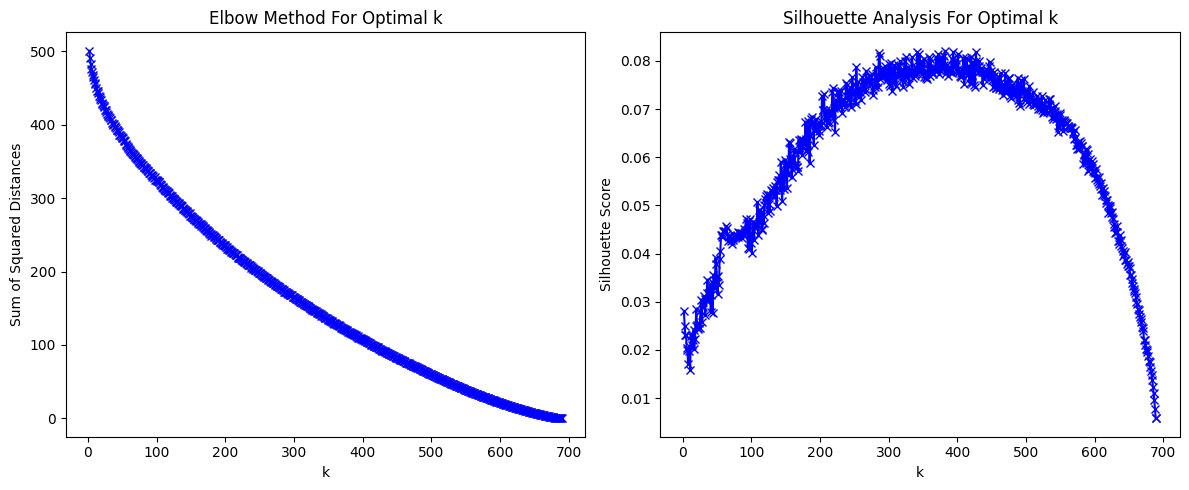

In [ ]:
#@title Euclidean Distance

# Determine the number of clusters
def determine_k(embeddings, max_k):
    K = range(2, max_k)
    sum_of_squared_distances = []
    silhouette_scores = []

    # Using a single loop to compute both metrics and identify the best k
    best_k, best_silhouette_score = None, -1

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embeddings)

        # Store inertia and silhouette score
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(embeddings, kmeans.labels_)

        sum_of_squared_distances.append(inertia)
        silhouette_scores.append(silhouette_avg)

        # Update best k if current silhouette score is better
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_k = k

    print(f"Optimal K - {best_k}")

    # Plotting the elbow curve and silhouette scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(K, sum_of_squared_distances, 'bx-')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Sum of Squared Distances')
    ax[0].set_title('Elbow Method For Optimal k')

    ax[1].plot(K, silhouette_scores, 'bx-')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].set_title('Silhouette Analysis For Optimal k')

    plt.tight_layout()
    plt.show()

# Run the function
print("Before")
determine_k(embeddings, max_k_guess)  # 418

print("After")
determine_k(context_embeddings, max_k_guess)  # 382

Before
Optimal K - 689


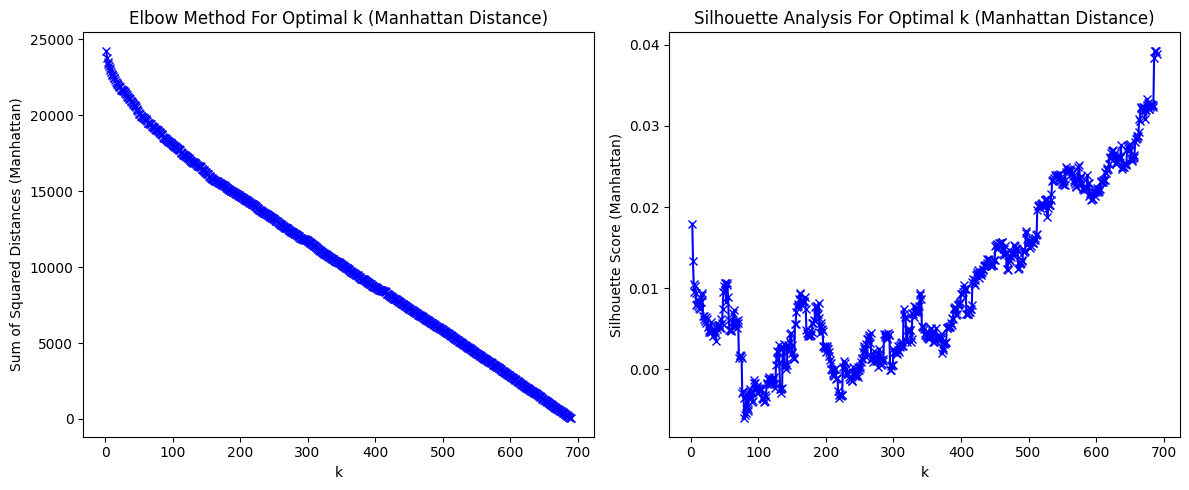

After


In [ ]:
#@title Manhattan Distance

# Optimized function for determining the number of clusters using Manhattan distance (L1 norm)
def determine_k_manhattan(embeddings, max_k):
    K = range(2, max_k)
    sum_of_squared_distances = []
    silhouette_scores = []

    best_silhouette_score = -1
    best_k = None

    for k in K:
        kmedoids = KMedoids(n_clusters=k, metric='manhattan', random_state=42).fit(embeddings)
        sum_of_squared_distances.append(kmedoids.inertia_)
        silhouette_avg = silhouette_score(embeddings, kmedoids.labels_, metric='manhattan')
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_k = k

    print(f"Optimal K - {best_k}")

    # Plotting the elbow curve and silhouette scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow Method plot
    ax[0].plot(K, sum_of_squared_distances, 'bx-')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Sum of Squared Distances (Manhattan)')
    ax[0].set_title('Elbow Method For Optimal k (Manhattan Distance)')

    # Silhouette Score plot
    ax[1].plot(K, silhouette_scores, 'bx-')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Silhouette Score (Manhattan)')
    ax[1].set_title('Silhouette Analysis For Optimal k (Manhattan Distance)')

    plt.tight_layout()
    plt.show()

# Suppress specific warning about empty clusters
warnings.filterwarnings("ignore", message="Cluster .* is empty!", category=UserWarning)

# Run the clustering code
print("Before")
determine_k_manhattan(embeddings, max_k_guess)

print("After")
determine_k_manhattan(context_embeddings, max_k_guess)

In [ ]:
#@title Cosine Similarity

# Optimized function to determine the number of clusters using cosine similarity
def determine_k_cosine(embeddings, max_k):
    K = range(2, max_k)
    sum_of_squared_distances = []
    silhouette_scores = []

    # Normalize the embeddings once for cosine similarity
    normalized_embeddings = normalize(embeddings)

    best_silhouette_score = -1
    best_k = None

    for k in K:
        # Perform KMeans clustering (note: inertia still uses Euclidean distance)
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(normalized_embeddings)
        sum_of_squared_distances.append(kmeans.inertia_)

        # Calculate silhouette score with cosine similarity
        silhouette_avg = silhouette_score(normalized_embeddings, kmeans.labels_, metric='cosine')
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_k = k

    print(f"Optimal K - {best_k}")

    # Plot the elbow curve and silhouette scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow Method plot
    ax[0].plot(K, sum_of_squared_distances, 'bx-')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Sum of Squared Distances')
    ax[0].set_title('Elbow Method For Optimal k')

    # Silhouette Score plot
    ax[1].plot(K, silhouette_scores, 'bx-')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Silhouette Score (Cosine Similarity)')
    ax[1].set_title('Silhouette Analysis For Optimal k (Cosine Similarity)')

    plt.tight_layout()
    plt.show()

# Run the function (Convergence warning if input > 678)
print("Before")
determine_k_cosine(embeddings, max_k_guess)  # 418

print("After")
determine_k_cosine(context_embeddings, max_k_guess)  # 382

Before


#### Gap Statistic

In [ ]:
# Optimized gap statistic function
def gap_statistic(embeddings, max_k, n_references):
    K = range(2, max_k)
    gaps = []
    ref_inertia_means = []

    # Get shape of the embeddings once
    shape = embeddings.shape

    for k in K:
        # Compute inertia for actual data
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(embeddings)
        disp = kmeans.inertia_

        # Compute reference inertia for random datasets
        random_data = np.random.uniform(0, 1, (n_references, *shape))
        reference_inertia = np.array([
            KMeans(n_clusters=k, random_state=42, n_init=10).fit(random_data[i]).inertia_
            for i in range(n_references)
        ])

        # Compute mean reference inertia and gap statistic
        ref_disp_mean = np.mean(reference_inertia)
        gaps.append(np.log(ref_disp_mean) - np.log(disp))
        ref_inertia_means.append(ref_disp_mean)

    # Determine optimal k based on maximum gap
    optimal_k = gaps.index(max(gaps)) + 2  # +2 because K starts from 2
    print(f"Optimal K (Gap Statistic): {optimal_k}")

    # Plot the gap statistic
    plt.plot(K, gaps, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic For Optimal k')
    plt.show()

# Run the gap statistic function
gap_statistic(embeddings, max_k_guess, 10)
gap_statistic(context_embeddings, max_k_guess, 10)

#### Davies-Bouldin Index (DBI)

In [ ]:
# Optimized Davies-Bouldin score function
def davies_bouldin(embeddings, max_k):
    K = range(2, max_k)
    dbi_scores = []

    for k in K:
        # Fit and predict in a single step
        labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(embeddings)

        # Calculate DBI score and store it
        dbi_scores.append(davies_bouldin_score(embeddings, labels))

    # Find optimal k with minimum DBI score
    optimal_k = K[dbi_scores.index(min(dbi_scores))]
    print(f"Optimal K (Davies-Bouldin): {optimal_k}")

    # Plot the Davies-Bouldin scores
    plt.plot(K, dbi_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('DBI For Optimal k')
    plt.show()

# Run the function
davies_bouldin(embeddings, max_k_guess)
davies_bouldin(context_embeddings, max_k_guess)

#### Calinski-Harabasz Index (Variance Ratio Criterion)

In [ ]:
# Optimized Calinski-Harabasz score function
def calinski_harabasz(embeddings, max_k):
    K = range(2, max_k)
    ch_scores = []
    best_score = -1
    best_k = None

    for k in K:
        # Fit and predict cluster labels in a single step
        labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(embeddings)

        # Calculate Calinski-Harabasz score
        score = calinski_harabasz_score(embeddings, labels)
        ch_scores.append(score)

        # Track the best score and corresponding k
        if score > best_score:
            best_score = score
            best_k = k

    print(f"Optimal K (Calinski-Harabasz): {best_k}")

    # Plot the Calinski-Harabasz scores
    plt.plot(K, ch_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('CH Index For Optimal k')
    plt.show()

# Run the function
calinski_harabasz(embeddings, max_k_guess)
calinski_harabasz(context_embeddings, max_k_guess)

#### Information Criterion Approaches

In [ ]:
# Optimized AIC/BIC score function
def aic_bic(embeddings, max_k):
    K = range(2, max_k)
    aic_scores = []
    bic_scores = []

    # Initialize variables to track the best scores and corresponding k
    best_aic, best_bic = float('inf'), float('inf')
    optimal_k_aic, optimal_k_bic = None, None

    for k in K:
        # Fit Gaussian Mixture Model
        gmm = GaussianMixture(n_components=k, random_state=42).fit(embeddings)

        # Calculate AIC and BIC
        aic = gmm.aic(embeddings)
        bic = gmm.bic(embeddings)

        # Append scores
        aic_scores.append(aic)
        bic_scores.append(bic)

        # Track the best scores
        if aic < best_aic:
            best_aic = aic
            optimal_k_aic = k
        if bic < best_bic:
            best_bic = bic
            optimal_k_bic = k

    # Print optimal K for AIC and BIC
    print(f"Optimal K (AIC): {optimal_k_aic}")
    print(f"Optimal K (BIC): {optimal_k_bic}")

    # Plot AIC and BIC scores
    plt.plot(K, aic_scores, 'bx-', label='AIC')
    plt.plot(K, bic_scores, 'rx-', label='BIC')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title('AIC/BIC For Optimal k')
    plt.legend()
    plt.show()

# Run the function
aic_bic(embeddings, max_k_guess)
aic_bic(context_embeddings, max_k_guess)

#### X-means Clustering

In [ ]:
np.warnings = warnings

# Optimized X-Means clustering
def x_means_clustering(embeddings):
    # Initialize KMeans++ centers with 2 initial clusters
    initial_centers = kmeans_plusplus_initializer(embeddings, 2).initialize()

    # Create and process X-Means instance
    xmeans_instance = xmeans(embeddings, initial_centers).process()

    # Get and print the optimal number of clusters
    print(f"Optimal K (X-Means): {len(xmeans_instance.get_clusters())}")

# Set up warnings outside the function
warnings.simplefilter("ignore")

# Run the optimized function
x_means_clustering(embeddings)
x_means_clustering(context_embeddings)

#### Cross-Validation Clustering

In [ ]:
# Optimized cross-validation clustering
def cross_val_clustering(embeddings, max_k):
    # Split the data once
    X_train, X_val = train_test_split(embeddings, test_size=0.2, random_state=42)
    K = range(2, max_k)
    val_scores = []

    # Iterate over different values of k
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_train)
        val_labels = kmeans.predict(X_val)
        val_scores.append(silhouette_score(X_val, val_labels))

    # Determine the optimal number of clusters
    optimal_k = K[val_scores.index(max(val_scores))]
    print(f"Optimal K (Cross-Validation): {optimal_k}")

# Run the optimized function
cross_val_clustering(embeddings, max_k_guess)
cross_val_clustering(context_embeddings, max_k_guess)

#### Dunn Index Clustering

In [ ]:
# Optimized Dunn index computation
def dunn_index(embeddings, labels):
    distances = squareform(pdist(embeddings))  # Calculate all pairwise distances once
    unique_labels = np.unique(labels)

    inter_distances = np.inf
    intra_distances = 0

    for i in unique_labels:
        # Intra-cluster distance (max within a cluster)
        intra_cluster = np.max(distances[labels == i][:, labels == i])
        intra_distances = max(intra_distances, intra_cluster)

        for j in unique_labels:
            if i != j:
                # Inter-cluster distance (min between clusters)
                inter_cluster = np.min(distances[labels == i][:, labels == j])
                inter_distances = min(inter_distances, inter_cluster)

    return inter_distances / intra_distances  # Return the Dunn index score

# Optimized clustering loop using Dunn index
def dunn_index_clustering(embeddings, max_k):
    K = range(2, max_k)
    dunn_scores = []

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(embeddings)
        labels = kmeans.labels_
        dunn_scores.append(dunn_index(embeddings, labels))

    optimal_k = K[dunn_scores.index(max(dunn_scores))]
    print(f"Optimal K (Dunn Index): {optimal_k}")

# Run the optimized Dunn index-based clustering
dunn_index_clustering(embeddings, max_k_guess)
dunn_index_clustering(context_embeddings, max_k_guess)

#### Eigen Gap Heuristic

In [ ]:
def eigen_gap(embeddings, max_k):
    # Create a kneighbors graph
    A = kneighbors_graph(embeddings, n_neighbors=5, mode='connectivity', include_self=False)

    # Compute the normalized Laplacian matrix
    L = csgraph.laplacian(A, normed=True)

    # Calculate the smallest eigenvalues
    eigenvalues, _ = eigs(L, k=max_k, which='SM')  # 'SM' for smallest magnitude eigenvalues
    eigenvalues = np.real(eigenvalues)  # Take real parts, ignoring imaginary parts

    # Sort eigenvalues and calculate gaps
    eigenvalues.sort()
    gaps = np.diff(eigenvalues)

    # Find the optimal number of clusters
    optimal_k = gaps.argmax() + 2  # +2 because k starts from 2
    print(f"Optimal K (Eigen Gap): {optimal_k}")

# Run the optimized eigen gap method
eigen_gap(embeddings, max_k_guess)
eigen_gap(context_embeddings, max_k_guess)

#### Jump Method

In [ ]:
def jump_method(embeddings, max_k):
    jumps = []
    K = range(2, max_k)

    # Preallocate jump values
    jumps = np.zeros(len(K) - 1)

    for i, k in enumerate(K):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embeddings)
        # Calculate the jump as the log of inertia
        jumps[i] = np.log(kmeans.inertia_)

    # Calculate the differences (jumps)
    jumps = np.diff(jumps)

    # Identify the optimal k based on the maximum jump
    optimal_k = K[np.argmax(jumps)]
    print(f"Optimal K (Jump Method): {optimal_k}")

# Run the optimized jump method
jump_method(embeddings, max_k_guess)
jump_method(context_embeddings, max_k_guess)

KeyboardInterrupt: 

### Finding Optimal K (All methods combined)

In [ ]:
np.warnings = warnings
warnings.filterwarnings("ignore")

# Define Dunn Index function
def dunn_index(embeddings, labels):
    distances = squareform(pdist(embeddings))
    unique_labels = np.unique(labels)
    inter_distances = []
    intra_distances = []

    for i in unique_labels:
        for j in unique_labels:
            if i != j:
                inter_distances.append(np.min(distances[labels == i][:, labels == j]))
        intra_distances.append(np.max(distances[labels == i][:, labels == i]))

    return np.min(inter_distances) / np.max(intra_distances)

def clustering_evaluation(embeddings, max_k, n_references=10):
    K = range(2, max_k)

    # Initialize data containers
    sum_of_squared_distances, silhouette_scores, gap_statistic, dbi_scores = [], [], [], []
    ch_scores, aic_scores, bic_scores, dunn_scores, eigen_gaps, jump_scores = [], [], [], [], [], []

    # Cross-validation split
    X_train, X_val = train_test_split(embeddings, test_size=0.2, random_state=42)
    shape = embeddings.shape
    reference_inertia = np.zeros((len(K), n_references))

    for k in K:
        # KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(embeddings)
        sum_of_squared_distances.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        val_labels = kmeans.predict(X_val)
        cross_val_score = silhouette_score(X_val, val_labels)

        # Davies-Bouldin Index
        dbi_scores.append(davies_bouldin_score(embeddings, kmeans.labels_))

        # Calinski-Harabasz Index
        ch_scores.append(calinski_harabasz_score(embeddings, kmeans.labels_))

        # AIC/BIC via Gaussian Mixture
        gmm = GaussianMixture(n_components=k, random_state=42).fit(embeddings)
        aic_scores.append(gmm.aic(embeddings))
        bic_scores.append(gmm.bic(embeddings))

        # Dunn Index
        dunn_scores.append(dunn_index(embeddings, kmeans.labels_))

        # X-Means
        initial_centers = kmeans_plusplus_initializer(embeddings, 2).initialize()
        xmeans_instance = xmeans(embeddings, initial_centers)
        xmeans_instance.process()

        # Jump Method
        jump_scores.append(np.log(kmeans.inertia_))

        # Gap Statistic
        disp = kmeans.inertia_
        for j in range(n_references):
            random_data = np.random.uniform(0, 1, shape)
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(random_data)
            reference_inertia[k, j] = km.inertia_

        ref_disp = np.mean(reference_inertia[k])
        gap_statistic.append(np.log(ref_disp) - np.log(disp))

        # Eigen Gap
        A = kneighbors_graph(embeddings, n_neighbors=5, mode='connectivity')
        L = laplacian(A, normed=True)
        eigenvalues = eigvals(L.toarray())
        eigenvalues.sort()
        gaps = np.diff(eigenvalues[:max_k])
        eigen_gaps.append(gaps.argmax() + 2)

    # Jump score calculation (difference of log inertia)
    jump_scores = np.diff(jump_scores)

    # Determine optimal K based on different methods
    optimal_k_silhouette = K[silhouette_scores.index(max(silhouette_scores))]
    optimal_k_dbi = K[dbi_scores.index(min(dbi_scores))]
    optimal_k_ch = K[ch_scores.index(max(ch_scores))]
    optimal_k_aic = K[aic_scores.index(min(aic_scores))]
    optimal_k_bic = K[bic_scores.index(min(bic_scores))]
    optimal_k_dunn = K[dunn_scores.index(max(dunn_scores))]
    optimal_k_eigen = K[eigen_gaps.index(max(eigen_gaps))]
    optimal_k_jump = K[np.argmax(jump_scores)]
    optimal_k_gap = K[gap_statistic.index(max(gap_statistic))]

    # Output optimal K's
    print(f"Optimal K (Silhouette): {optimal_k_silhouette}")
    print(f"Optimal K (Davies-Bouldin): {optimal_k_dbi}")
    print(f"Optimal K (Calinski-Harabasz): {optimal_k_ch}")
    print(f"Optimal K (AIC): {optimal_k_aic}")
    print(f"Optimal K (BIC): {optimal_k_bic}")
    print(f"Optimal K (Dunn): {optimal_k_dunn}")
    print(f"Optimal K (Eigen Gap): {optimal_k_eigen}")
    print(f"Optimal K (Jump Method): {optimal_k_jump}")
    print(f"Optimal K (Gap Statistic): {optimal_k_gap}")

    # Plot combined metrics
    fig, ax = plt.subplots(3, 3, figsize=(18, 18))
    ax[0, 0].plot(K, silhouette_scores, 'bx-')
    ax[0, 0].set_title('Silhouette Score')
    ax[0, 1].plot(K, dbi_scores, 'bx-')
    ax[0, 1].set_title('Davies-Bouldin Index')
    ax[0, 2].plot(K, ch_scores, 'bx-')
    ax[0, 2].set_title('Calinski-Harabasz Index')
    ax[1, 0].plot(K, aic_scores, 'bx-')
    ax[1, 0].set_title('AIC')
    ax[1, 1].plot(K, bic_scores, 'bx-')
    ax[1, 1].set_title('BIC')
    ax[1, 2].plot(K, dunn_scores, 'bx-')
    ax[1, 2].set_title('Dunn Index')
    ax[2, 0].plot(K, eigen_gaps, 'bx-')
    ax[2, 0].set_title('Eigen Gap')
    ax[2, 1].plot(K, jump_scores, 'bx-')
    ax[2, 1].set_title('Jump Method')
    ax[2, 2].plot(K, gap_statistic, 'bx-')
    ax[2, 2].set_title('Gap Statistic')

    plt.tight_layout()
    plt.show()

# Run combined function
print("Before")
clustering_evaluation(embeddings, max_k_guess)

print("After")
clustering_evaluation(context_embeddings, max_k_guess)

Before


### Clustering

In [ ]:
#@title Cluster Distribution Histogram

# Configure the number of clusters

# Initialize KMeans and fit it to your embeddings
kmeans = KMeans(n_clusters=418, random_state=42)
df['KMeans_cluster'] = kmeans.fit_predict(embeddings)

context_kmeans = KMeans(n_clusters=382, random_state=42)
df['Context_KMeans_cluster'] = kmeans.fit_predict(context_embeddings)

# Review the distribution of clusters
cluster_counts = df['KMeans_cluster'].value_counts().sort_index()

context_cluster_counts = df['Context_KMeans_cluster'].value_counts().sort_index()

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Points per Cluster')
plt.title('Distribution of Points in Each Cluster')
print("Before")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=context_cluster_counts.index, y=context_cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Points per Cluster')
plt.title('Distribution of Points in Each Cluster')
print("After")
plt.show()

In [ ]:
#@title PCA Visualization of Clusters

# Fit PCA for embeddings
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(embeddings)

context_pca = PCA(n_components=2, random_state=42)
context_pca_embeddings = context_pca.fit_transform(context_embeddings)

# Assuming 'text' is the column with the questions in your df
df['PCA1'] = pca_embeddings[:, 0]
df['PCA2'] = pca_embeddings[:, 1]

# Group the data by cluster and concatenate questions
df_grouped = df.groupby('KMeans_cluster').agg({
    'PCA1': 'mean',  # Compute the mean PCA position for each cluster
    'PCA2': 'mean',
    'text': lambda x: '<br>'.join(x)  # Concatenate multiple questions with line breaks
}).reset_index()

# Interactive plot for the first PCA
fig = px.scatter(df_grouped, x='PCA1', y='PCA2', color='KMeans_cluster', hover_data=['text'],
                 title='PCA Visualization of Clusters', labels={'color': 'Cluster'})

fig.show()

# Group context PCA data
df_context_grouped = df.groupby('Context_KMeans_cluster').agg({
    'Context_PCA1': 'mean',
    'Context_PCA2': 'mean',
    'final_text': lambda x: '<br>'.join(x)  # Concatenate questions for context clusters
}).reset_index()

# Interactive plot for the context PCA
fig_context = px.scatter(df_context_grouped, x='Context_PCA1', y='Context_PCA2', color='Context_KMeans_cluster',
                         hover_data=['final_text'], title='PCA Visualization of Context Clusters',
                         labels={'color': 'Cluster'})

fig_context.show()

## t-SNE

In [ ]:
#@title t-SNE Visualization of Clusters

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1)) # Manual perplexity adjusgment to fix error for very small data sample
reduced_embeddings = tsne.fit_transform(embeddings)

context_tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(context_embeddings)-1)) # Manual perplexity adjusgment to fix error for very small data sample
context_reduced_embeddings = context_tsne.fit_transform(context_embeddings)

# Plot the results with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['KMeans_cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of text clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
print("Before")
plt.show()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(context_reduced_embeddings[:, 0], context_reduced_embeddings[:, 1], c=df['Context_KMeans_cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of text clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
print("Before")
plt.show()

In [ ]:
# Assume embeddings and context_embeddings are already defined
# Fit t-SNE for embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
reduced_embeddings = tsne.fit_transform(embeddings)

# Fit t-SNE for context embeddings
context_tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(context_embeddings)-1))
context_reduced_embeddings = context_tsne.fit_transform(context_embeddings)

# Create DataFrame for embeddings
df['tSNE1'] = reduced_embeddings[:, 0]
df['tSNE2'] = reduced_embeddings[:, 1]

# Aggregate text for each cluster
df_grouped = df.groupby('KMeans_cluster').agg({
    'tSNE1': 'mean',  # Compute the mean t-SNE position for each cluster
    'tSNE2': 'mean',
    'text': lambda x: '<br>'.join(x)  # Concatenate texts with line breaks
}).reset_index()

# Interactive plot for t-SNE embeddings
fig_embeddings = px.scatter(
    df_grouped,
    x='tSNE1',
    y='tSNE2',
    color='KMeans_cluster',
    hover_data=['text'],  # This will display the aggregated 'text' on hover
    title='t-SNE Visualization of Text Clusters',
    labels={'color': 'Cluster'}
)

fig_embeddings.show()

# Create DataFrame for context embeddings
df['Context_tSNE1'] = context_reduced_embeddings[:, 0]
df['Context_tSNE2'] = context_reduced_embeddings[:, 1]

# Aggregate context text for each cluster
df_context_grouped = df.groupby('Context_KMeans_cluster').agg({
    'Context_tSNE1': 'mean',
    'Context_tSNE2': 'mean',
    'final_text': lambda x: '<br>'.join(x)  # Concatenate texts for context clusters
}).reset_index()

# Interactive plot for t-SNE context embeddings
fig_context_embeddings = px.scatter(
    df_context_grouped,
    x='Context_tSNE1',
    y='Context_tSNE2',
    color='Context_KMeans_cluster',
    hover_data=['final_text'],  # This will display the aggregated 'final_text' on hover
    title='t-SNE Visualization of Context Clusters',
    labels={'color': 'Cluster'}
)

fig_context_embeddings.show()

In [ ]:
#@title HDBSCAN Clustering Visualization via t-SNE

# Convert the embeddings back to a numpy array
df['text_embeddings'] = df['text_embeddings'].apply(lambda x: eval(str(x)))
embeddings = np.stack(df['text_embeddings'].values)

df['final_text_embeddings'] = df['final_text_embeddings'].apply(lambda x: eval(str(x)))
disambiguated_embeddings = np.stack(df['final_text_embeddings'].values)

# HDBSCAN parameters
hdbscan_min_samples = 1
hdbscan_min_cluster_size = 5
hdbscan_max_cluster_size = 500
hdbscan_cluster_selection_method = "leaf"  # can be "leaf" or "eom"
prediction_data = False

# Initialize and fit HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_samples=hdbscan_min_samples,
    min_cluster_size=hdbscan_min_cluster_size,
    max_cluster_size=hdbscan_max_cluster_size,
    cluster_selection_method=hdbscan_cluster_selection_method,
    prediction_data=prediction_data
)

# Fit HDBSCAN on embeddings
labels = clusterer.fit(embeddings).labels_
disambiguated_labels = clusterer.fit(disambiguated_embeddings).labels_

# Store the cluster labels in the DataFrame
df['HDBSCAN_cluster'] = labels
df['Disambiguated_HDBSCAN_cluster'] = disambiguated_labels

# Apply t-SNE to reduce dimensionality for visualization (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df) - 1))
embeddings_2d = tsne.fit_transform(embeddings)

# Add t-SNE results to the original DataFrame
df['tSNE1'] = embeddings_2d[:, 0]
df['tSNE2'] = embeddings_2d[:, 1]

# Aggregate text for each HDBSCAN cluster
df_grouped = df.groupby('HDBSCAN_cluster').agg({
    'tSNE1': 'mean',  # Compute the mean t-SNE position for each cluster
    'tSNE2': 'mean',
    'text': lambda x: '<br>'.join(x)  # Concatenate texts for clusters
}).reset_index()

# Create interactive plot for HDBSCAN clusters
fig = px.scatter(
    df_grouped,
    x='tSNE1',
    y='tSNE2',
    color='HDBSCAN_cluster',
    hover_data=['text'],  # This will display the aggregated 'text' on hover
    title='HDBSCAN Clustering Visualization with t-SNE',
    labels={'color': 'Cluster'}
)

fig.show()

# For disambiguated clusters, repeat the process
df['final_text'] = df['final_text']  # Ensure you have the correct text column for disambiguation
disambiguated_tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df) - 1))
disambiguated_embeddings_2d = disambiguated_tsne.fit_transform(disambiguated_embeddings)

# Add t-SNE results to the original DataFrame for disambiguated clusters
df['Disambiguated_tSNE1'] = disambiguated_embeddings_2d[:, 0]
df['Disambiguated_tSNE2'] = disambiguated_embeddings_2d[:, 1]

# Aggregate text for each disambiguated HDBSCAN cluster
df_disambiguated_grouped = df.groupby('Disambiguated_HDBSCAN_cluster').agg({
    'Disambiguated_tSNE1': 'mean',
    'Disambiguated_tSNE2': 'mean',
    'final_text': lambda x: '<br>'.join(x),  # Concatenate texts for disambiguated clusters
}).reset_index()

# Create interactive plot for disambiguated HDBSCAN clusters
fig_disambiguated = px.scatter(
    df_disambiguated_grouped,
    x='Disambiguated_tSNE1',
    y='Disambiguated_tSNE2',
    color='Disambiguated_HDBSCAN_cluster',
    hover_data=['final_text'],  # This will display the aggregated 'final_text' on hover
    title='Disambiguated HDBSCAN Clustering Visualization with t-SNE',
    labels={'color': 'Cluster'}
)

fig_disambiguated.show()

## 3D Visualization

In [ ]:
#@title Tokenize disambiguated text

nlp = spacy.load("en_core_web_sm")

def tokenize(text):
    # Tokenize the text
    doc = nlp(str(text))
    return [token.text for token in doc]

processed_df = fortunoff_df[fortunoff_df['final_text'].str.len() > 1].copy()

# Apply the tokenizer to each row in the DataFrame
processed_df['text_tokenized'] = processed_df['text'].apply(tokenize)
processed_df['disambiguated_text_tokenized'] = processed_df['disambiguated_text'].apply(tokenize)

processed_df

In [ ]:
#@title Display differences in tokens' frequencies

# Count tokens in each row for both tokenized columns
text_tokens_concatenated = [token for row in processed_df['text_tokenized'] for token in row]
disambiguated_tokens_concatenated = [token for row in processed_df['disambiguated_text_tokenized'] for token in row]

# Count the frequency of each token in the concatenated lists
text_token_counts = Counter(text_tokens_concatenated)
disambiguated_token_counts = Counter(disambiguated_tokens_concatenated)

# Convert frequencies to DataFrames
original_text_frequencies = pd.DataFrame(text_token_counts.items(), columns=['Token', 'Original_Text_Token_Frequency'])
disambiguated_text_frequencies = pd.DataFrame(disambiguated_token_counts.items(), columns=['Token', 'Disambiguated_Token_Frequency'])

# Merge the two DataFrames on the 'Token' column
merged_df = pd.merge(original_text_frequencies, disambiguated_text_frequencies, on='Token', how='outer').fillna(0)

# Calculate the difference in frequencies
merged_df['Frequency_Difference'] = merged_df['Disambiguated_Token_Frequency'] - merged_df['Original_Text_Token_Frequency']
merged_df['Frequency_Absolute_Difference'] = abs(merged_df['Frequency_Difference'])

# Show most removed words
merged_df.sort_values(by=['Frequency_Difference', 'Token'], ascending=[True, True])

# Only show words with sensitive topics
keys = ['persecute',
        'execute',
        'starve',
        'torture',
        'murder',
        'kill',
        'dehumanize',
        'naked',
        'rape',
        'strip',
        'sterilize',
        'gas',
        'exterminate',
        'humiliate',
        'burn',
        'experiment',
        'displace',
        'slaughtered',
        'genocide',
        'beat',
        'pierce',
        'death',
        'flesh',
        'poison',
        'massacre',
        'suicide',
        'atrocity',
        'atrocities',
        'camp',
        'holocaust',
        'discrimination',
        'oppression',
        'brutality',
        'execution',
        'forced labor',
        'cleansing',
        'atrocious',
        'inhumane',
        'grave',
        'crematorium',
        'separation',
        'disenfranchise',
        'emaciated',
        'deportation',
        'purge',
        'crime']

sensitive_df = merged_df[merged_df['Token'].isin(keys)]
sensitive_df = sensitive_df.sort_values(by = ['Frequency_Difference'], ascending = [True])

sensitive_df

In [ ]:
#@title 3D visualization of clusters as a function of frequency difference

# Filter out tokens that have no frequency change
difference_df = merged_df[merged_df['Frequency_Difference'] != 0].copy()

## Calcuate Embedding for Token in merged_df
difference_df['text_embedding'] = difference_df['Token'].apply(lambda x: nlp(x).vector)

# cluster text embeddings with k-means
from sklearn.cluster import KMeans
import numpy as np

embeddings = np.array(difference_df['text_embedding'].tolist())
kmeans = KMeans(n_clusters=9, n_init=10, random_state=0).fit(embeddings)
clusters = kmeans.labels_
difference_df['cluster'] = clusters

# Plot the clusters
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

#Dimensonality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
difference_df['PCA1'] = reduced_embeddings[:, 0]
difference_df['PCA2'] = reduced_embeddings[:, 1]

# Get unique clusters and generate colors for each cluster
unique_clusters = difference_df['cluster'].unique()
num_clusters = len(unique_clusters)

# Use a color scale or palette (Alphabet has 26 colors)
if num_clusters <= len(px.colors.qualitative.Alphabet):
    # Set colors equal to the colors from the swatch
    colors = px.colors.qualitative.Set1[:num_clusters]
else:
    # Use a sequential color scale if more than 26 clusters
    colors = px.colors.sequential.Plasma

# Create a set of colors for the colors that we generated
color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Create the interactive scatter plot
fig = px.scatter_3d(
    difference_df,
    x='PCA1',
    y='PCA2',
    z='Frequency_Difference',  # Use frequency difference as the z-axis
    color='cluster',
    hover_name='Token',  # Show token on hover
    title='3D Scatter Plot with Frequency Difference as an Axis',
    labels={'Cluster': 'Cluster'},

)

# Show plot
fig.show()